# Imports and Constants

### Data Loading

In [2]:
!pip install datasets

import torch
from torch import nn
from datasets import load_dataset
from torch.utils.data import DataLoader

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 485.4/485.4 kB 8.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 11.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 143.5/143.5 kB 9.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.8/194.8 kB 13.7 MB/s eta 0:00:00


In [3]:
LANGUAGES = ["en", "de", "nl", "sv-SE", "da"]
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
LEARNING_RATE = 0.001
NUM_EPOCHS = 10
BATCH_SIZE = 50
TRAIN_BATCH = 100
VAL_BATCH = 100
SAMPLE_RATE = 48000

# Constants related to the MFCC processing
# the number of samples per fft
N_FFT = 2048
# the amount of transform to shift
HOP_LENGTH = 512
# The number of coefficient we extract
N_MFCC = 13

### Data Processing

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pylab as plt
import seaborn as sns

from glob import glob # list out files in directory -> reading wave files

import librosa
import librosa.display
import IPython.display as ipd # play files

from itertools import cycle # colours and gimiks

### Training

In [5]:
import numpy as np
import time
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
from torch.utils.data.sampler import SubsetRandomSampler
import torchvision.transforms as transforms

# Download Dataset

In [6]:
# linking hugging face account
!huggingface-cli login


    _|    _|  _|    _|    _|_|_|    _|_|_|  _|_|_|  _|      _|    _|_|_|      _|_|_|_|    _|_|      _|_|_|  _|_|_|_|
    _|    _|  _|    _|  _|        _|          _|    _|_|    _|  _|            _|        _|    _|  _|        _|
    _|_|_|_|  _|    _|  _|  _|_|  _|  _|_|    _|    _|  _|  _|  _|  _|_|      _|_|_|    _|_|_|_|  _|        _|_|_|
    _|    _|  _|    _|  _|    _|  _|    _|    _|    _|    _|_|  _|    _|      _|        _|    _|  _|        _|
    _|    _|    _|_|      _|_|_|    _|_|_|  _|_|_|  _|      _|    _|_|_|      _|        _|    _|    _|_|_|  _|_|_|_|

    To log in, `huggingface_hub` requires a token generated from https://huggingface.co/settings/tokens .
Enter your token (input will not be visible): 
Add token as git credential? (Y/n) n
Token is valid (permission: read).
The token `CommonVoice` has been saved to /root/.cache/huggingface/stored_tokens
Your token has been saved to /root/.cache/huggingface/token
Login successful.
The current active token is: `CommonVoice`


In [7]:
def load_data(languages, train_batch, val_batch):
  train_data = []
  val_data = []

  train_audio = []
  train_labels = []
  train_sr = []
  val_audio = []
  val_labels = []
  val_sr = []

  one_hot = F.one_hot(torch.tensor([0, 1, 2, 3, 4]), num_classes=len(languages))

  for i in range(len(one_hot)):
    one_hot[i] = one_hot[i].to(dtype=torch.float)

  for i in range(len(languages)):
    # Load common voice 17 dataset training set with streaming, and enabling custom code (necessary to load dataset correctly)
    train_data.append(load_dataset("mozilla-foundation/common_voice_17_0", languages[i], split="train", streaming=True, cache_dir='/content/my_cache', trust_remote_code=True))
    val_data.append(load_dataset("mozilla-foundation/common_voice_17_0", languages[i], split="validation", streaming=True, cache_dir='/content/my_cache', trust_remote_code=True))

    it = iter(train_data[i])
    it2 = iter(val_data[i])

    for j in range(train_batch):
      train_item = next(it)

      if train_item:
        train_audio.append(train_item['audio']['array'])
        train_sr.append(train_item['audio']['sampling_rate'])
        train_labels.append(one_hot[i])

    for j in range(val_batch):
      val_item = next(it2)

      if val_item:
        val_audio.append(val_item['audio']['array'])
        val_sr.append(val_item['audio']['sampling_rate'])
        val_labels.append(one_hot[i])


    print(f"Loaded {languages[i]}")

  return train_audio, train_labels, train_sr, val_audio, val_labels, val_sr

In [8]:
train_audio, train_labels, train_sr, val_audio, val_labels, val_sr = load_data(LANGUAGES, TRAIN_BATCH, VAL_BATCH)

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


README.md:   0%|          | 0.00/12.7k [00:00<?, ?B/s]

common_voice_17_0.py:   0%|          | 0.00/8.19k [00:00<?, ?B/s]

languages.py:   0%|          | 0.00/3.92k [00:00<?, ?B/s]

release_stats.py:   0%|          | 0.00/132k [00:00<?, ?B/s]

Reading metadata...: 1101170it [00:18, 60903.74it/s]
Reading metadata...: 16393it [00:00, 42676.85it/s]


Loaded en


Reading metadata...: 589100it [00:14, 39978.33it/s]
Reading metadata...: 16183it [00:00, 31259.51it/s]


Loaded de


Reading metadata...: 34898it [00:00, 50132.07it/s]
Reading metadata...: 11252it [00:00, 37914.14it/s]


Loaded nl


Reading metadata...: 7744it [00:00, 40158.47it/s]
Reading metadata...: 5210it [00:00, 32643.13it/s]


Loaded sv-SE


Reading metadata...: 3484it [00:00, 20001.50it/s]
Reading metadata...: 2105it [00:00, 16722.88it/s]


Loaded da


# Data Processing

### Sanity Check

In [ ]:
# Preprocessing audio

def process_batch(audio_data, sample_rates, batch_size):
  audio_processed = []
  LENGTH =  5 * SAMPLE_RATE # (5 sec)

  for i in range(batch_size):
    # Resample
    audio_resampled = librosa.resample(audio_data[i], orig_sr = sample_rates[i], target_sr = SAMPLE_RATE)

    # Trimming decibels
    audio_trimmed, _ = librosa.effects.trim(audio_resampled, top_db=80)

    # if audio too long trim down length
    if len(audio_trimmed) > LENGTH:
      audio_trimmed = audio_trimmed[:LENGTH]

    # if audio too short, add padding
    elif len(audio_trimmed) < LENGTH:
      padding =  LENGTH - len(audio_trimmed)
      audio_trimmed = np.pad(audio_trimmed, (0, padding), mode='constant')

    # Calculate MFCCs for the trimmed audio
    audio_trimmed = librosa.feature.mfcc(y = np.abs(audio_trimmed), sr=SAMPLE_RATE, n_fft=N_FFT, hop_length=HOP_LENGTH, n_mfcc=N_MFCC)

    # Add to processed array
    audio_processed.append(audio_trimmed)

  return audio_processed

(13, 288)


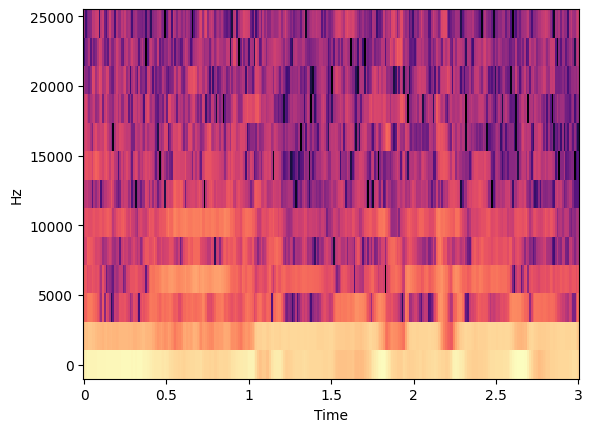

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
from matplotlib import cm

TEST_INDEX = 1

MFCC_data = process_batch(train_audio, train_sr, len(train_audio))

D = librosa.amplitude_to_db(np.abs(MFCC_data[TEST_INDEX]), ref=np.max)
img = librosa.display.specshow(D, y_axis='linear', x_axis='time', sr=SAMPLE_RATE)

print(MFCC_data[TEST_INDEX].shape)

### Dataset Class

In [9]:
import torch
from torch.utils.data import Dataset, DataLoader
import librosa
import numpy as np

class AudioDataset(Dataset):
    def __init__(self, audios, labels, sample_rates, n_fft=N_FFT, hop_length=HOP_LENGTH, n_mfcc=N_MFCC, transform=None):
        """
        audios: list of raw audio arrays
        labels: list of labels
        """
        self.audios = audios
        self.labels = labels
        self.sample_rates = sample_rates
        self.n_fft = n_fft
        self.hop_length = hop_length
        self.n_mfcc = n_mfcc
        self.transform = transform

    def __len__(self):
        return len(self.audios)

    def __getitem__(self, idx):
        audio = self.audios[idx]
        label = self.labels[idx]
        sr = self.sample_rates[idx]

        audio_length = SAMPLE_RATE*5

        # Resample
        audio_resampled = librosa.resample(audio, orig_sr = sr, target_sr = SAMPLE_RATE)

        # Trimming decibels
        audio_trimmed, _ = librosa.effects.trim(audio_resampled, top_db=80)

        # if audio too long trim down length (5 secs)
        if len(audio_trimmed) > audio_length:
          audio_trimmed = audio_trimmed[:audio_length]

        # if audio too short, add padding
        elif len(audio_trimmed) < audio_length:
          padding = audio_length - len(audio_trimmed)
          audio_trimmed = np.pad(audio_trimmed, (0, padding), mode='constant')

        # Calculate MFCCs for the trimmed audio
        mfcc = librosa.feature.mfcc(y = np.abs(audio_trimmed), sr=SAMPLE_RATE, n_fft=self.n_fft, hop_length=self.hop_length, n_mfcc=self.n_mfcc)
        mfcc = torch.tensor(mfcc, dtype=torch.float)

        return mfcc, label

In [10]:
audio_dataset = AudioDataset(train_audio, train_labels, train_sr)
train_loader = DataLoader(audio_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=2)

# CNN Model

In [19]:
class ConvNetwork(nn.Module):
  def __init__(self):
    super().__init__()

    self.c1 = nn.Sequential(
      nn.Conv2d(
        in_channels=1,
        out_channels=32,
        kernel_size=3,
        stride=1,
        padding=2,
      ),
      nn.BatchNorm2d(32),
      nn.ReLU(),
      nn.MaxPool2d(kernel_size=2),
      nn.Dropout(p=0.2)
    )

    self.c2 = nn.Sequential(
      nn.Conv2d(
        in_channels=32,
        out_channels=64,
        kernel_size=3,
        stride=1,
        padding=2
      ),
      nn.BatchNorm2d(64),
      nn.ReLU(),
      nn.MaxPool2d(kernel_size=2),
      nn.Dropout(p=0.2)
    )

    self.c3 = nn.Sequential(
      nn.Conv2d(
        in_channels=64,
        out_channels=128,
        kernel_size=3,
        stride=1,
        padding=2
      ),
      nn.BatchNorm2d(128),
      nn.ReLU(),
      nn.MaxPool2d(kernel_size=2),
      nn.Dropout(p=0.2)
    )

    self.global_max = nn.MaxPool2d(kernel_size=2)
    self.flatten = nn.Flatten()
    self.linear = nn.Linear(3840, len(LANGUAGES)) # BATCH_SIZE or other params
    self.softmax = nn.Softmax(dim=1)

  def forward(self, input):
    input = input.unsqueeze(1)
    input = input.squeeze(0)
    x = self.c1(input)
    x = self.c2(x)
    x = self.c3(x)
    x = self.global_max(x)
    x = self.flatten(x)
    logits = self.linear(x)
    predictions = self.softmax(logits)
    return logits, predictions

### Training

In [12]:
from google.colab import drive
import os
drive.mount('/content/drive')

Mounted at /content/drive


In [13]:
def save_result(model_code, train_err, train_loss, val_err, val_loss):
  save_dir = "/content/drive/My Drive/training_results"
  os.makedirs(save_dir, exist_ok=True)
  model_path = os.path.join(save_dir, model_code)
  np.savetxt("{}_train_err.csv".format(model_path), train_err)
  np.savetxt("{}_train_loss.csv".format(model_path), train_loss)
  np.savetxt("{}_val_err.csv".format(model_path), val_err)
  np.savetxt("{}_val_loss.csv".format(model_path), val_loss)


def save_weight(net, model_code):
  """model code will be a string code we assigned to each model"""
  weight_dir = "/content/drive/My Drive/model_weights"
  os.makedirs(weight_dir, exist_ok=True)

  model_path = os.path.join(weight_dir, model_code)
  torch.save(net.state_dict(), f"{model_path}.pth")


def load_weight(net, model_code):
  """model code will be a string code we assigned to each model"""
  weight_dir = "/content/drive/My Drive/model_weights"
  model_path = os.path.join(weight_dir, model_code)

  net.load_state_dict(torch.load(f"{model_path}.pth"))
  net.eval()
  return net

In [14]:
def plot_training_curve(model_code):
    import matplotlib.pyplot as plt

    save_dir = "/content/drive/My Drive/training_results"
    path = os.path.join(save_dir, model_code)

    train_err = np.loadtxt("{}_train_err.csv".format(path))
    val_err = np.loadtxt("{}_val_err.csv".format(path))
    train_loss = np.loadtxt("{}_train_loss.csv".format(path))
    val_loss = np.loadtxt("{}_val_loss.csv".format(path))

    # plt.title("Train vs Validation Error")
    plt.title("Train Error")
    n = len(train_err) # number of epochs
    plt.plot(range(1,n+1), train_err, label="Train")
    # plt.plot(range(1,n+1), val_err, label="Validation")
    plt.xlabel("Epoch")
    plt.ylabel("Error")
    plt.legend(loc='best')
    plt.show()
    # plt.title("Train vs Validation Loss")
    plt.title("Train Loss")
    plt.plot(range(1,n+1), train_loss, label="Train")
    # plt.plot(range(1,n+1), val_loss, label="Validation")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend(loc='best')
    plt.show()

In [15]:
def train(model, model_name, data_loader, device, optimizer, loss_function, num_epochs):
  start_time = time.time()
  train_err = np.zeros(num_epochs)
  train_loss = np.zeros(num_epochs)
  val_err = np.zeros(num_epochs)
  val_loss = np.zeros(num_epochs)
  total_train_err = 0
  total_train_loss = 0

  for epoch in range(num_epochs):
    for data, label in data_loader:
      logits, predictions = model(data)
      loss = loss_function(logits, label.to(dtype=torch.float))

      optimizer.zero_grad()
      loss.backward()
      optimizer.step()

      corr = (logits > 0.0).squeeze().long() != label
      train_err[epoch] = int(corr.sum())/len(label)
      train_loss[epoch] = loss.item()

      # val_err[epoch], val_loss[epoch] = evaluate(net, val_loader, criterion)

    save_weight(cnn, f"{model_name}_epoch_{epoch + 1}")
    print(f"Epoch #{epoch + 1} | Loss: {train_loss[epoch]} | Error: {train_err[epoch]}")

  save_result(model_name, train_err, train_loss, val_err, val_loss)

  end_time = time.time()
  elapsed_time = end_time - start_time
  print(f"Time elapsed: {elapsed_time:.4f} seconds")

In [ ]:
m_name = "cnn_test_2"

cnn = ConvNetwork()

loss_function = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(cnn.parameters(), lr=LEARNING_RATE)

train(cnn, m_name, train_loader, DEVICE, optimizer, loss_function, NUM_EPOCHS)

plot_training_curve(m_name)

Epoch #1 | Loss: 1.7808914184570312 | Error: 3.18
Epoch #2 | Loss: 1.2338621616363525 | Error: 2.38


### Evaluation

In [ ]:
def normalize_label(labels):
    """
    Given a tensor containing 2 possible values, normalize this to 0/1

    Args:
        labels: a 1D tensor containing two possible scalar values
    Returns:
        A tensor normalize to 0/1 value
    """
    max_val = torch.max(labels)
    min_val = torch.min(labels)
    norm_labels = (labels - min_val)/(max_val - min_val)
    return norm_labels

def evaluate(net, loader, criterion):
    """ Evaluate the network on the validation set.

     Args:
         net: PyTorch neural network object
         loader: PyTorch data loader for the validation set
         criterion: The loss function
     Returns:
         err: A scalar for the avg classification error over the validation set
         loss: A scalar for the average loss function over the validation set
     """
    total_loss = 0.0
    total_err = 0.0
    total_epoch = 0
    for i, data in enumerate(loader, 0):
        inputs, labels = data
        labels = normalize_label(labels)  # Convert labels to 0/1
        outputs = net(inputs)
        loss = criterion(outputs, labels.float())
        corr = (outputs > 0.0).squeeze().long() != labels
        total_err += int(corr.sum())
        total_loss += loss.item()
        total_epoch += len(labels)
    err = float(total_err) / total_epoch
    loss = float(total_loss) / (i + 1)
    return err, loss